# Model Training - Phasebased
This model architecture also takes phase information into account.

For that, the phases have to be normalized accordingly.

## Imports
This notebook uses the custom code found in the code folder

In [67]:
import os

# math, processing, deep learning
import numpy as np
import tensorflow as tf
from scipy.signal import stft, istft

# visualization
import matplotlib.pyplot as plt
from ipywidgets import interact
from mpl_toolkits.axes_grid1 import make_axes_locatable


# custom code
from code.stftprocessing import StftDataset
from code.dsvisual import DatasetVisualizer

# convenience
from tqdm import tqdm
import datetime


## Load the files for training and testing
There are different training and test sets in the folder. This section loads the appropriate ones into memory.


In [2]:
# this is a smaller training set for testing purposes
folder = "training/new_small"
base = "noisy_small"
target = "pure_small"

# this is a training set for training the main model
# folder = "training/original training"
# base = "noisy"
# target = "pure"

test_folder = "training/test set"
test_base = "noisy_test"
test_target = "pure_test"


Load the files from the given locations using the custom code StftDataset class.

The StftDataset class also processes the waveforms into STFT format.

In [3]:
noisy_stft = StftDataset()
pure_stft = StftDataset()

noisy_stft.load(folder, base)
pure_stft.load(folder, target)

# test sets
noisy_test_stft = StftDataset()
pure_test_stft = StftDataset()
noisy_test_stft.load(test_folder, test_base)
pure_test_stft.load(test_folder, test_target)

Files loaded.
Files loaded.
Files loaded.
Files loaded.


Check the shape of the data

In [4]:
noisy_stft.get_data().shape

(10000, 129, 9, 2)

### Extracting phase and amplitude information
The StftDataset class loads the data that was stored in amplitude and phase format in different files and combines it together

In [33]:
# get the amplitudes of training and test sets
examples = noisy_stft.get_data()[:,:,:,0]
labels = pure_stft.get_data()[:,:,:,0]

stride_reduce = 100
examples_test = noisy_test_stft.get_data()[::stride_reduce,:,:,0]
labels_test = pure_test_stft.get_data()[::stride_reduce,:,:,0]

# examples_test_phase = noisy_test_stft.get_data()[::stride_reduce,:,:,1]
# labels_test_phase = pure_test_stft.get_data()[::stride_reduce,:,:,1]

# build the dataset from tensorflow functions
train_dataset = tf.data.Dataset.from_tensor_slices((examples, labels))
test_dataset = tf.data.Dataset.from_tensor_slices((examples_test, labels_test))

In [34]:
train_dataset
# test_dataset

<TensorSliceDataset shapes: ((129, 9), (129, 9)), types: (tf.float64, tf.float64)>

In [35]:
input_shape = examples.shape[1:]
# count up the number of elements in the data for the flattened layer
number_of_data_elements = np.prod(input_shape)

In [36]:
BATCH_SIZE = 512
SHUFFLE_BUFFER_SIZE = 2000

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [37]:
train_dataset.take(1).unbatch()
   

<_UnbatchDataset shapes: ((129, 9), (129, 9)), types: (tf.float64, tf.float64)>

In [38]:
class Custom_Loss(tf.keras.losses.Loss):

    def call(self, y_true, y_pred):        
        # log_y_pred = tf.math.log(y_pred)
        # elements = -tf.math.multiply_no_nan(x=log_y_pred, y=y_true)
        
        # return tf.reduce_mean(tf.reduce_sum(elements,axis=1))
        # print(y_pred.shape)
        return tf.reduce_mean(tf.math.square(y_pred[:,:,:] - y_true[:,:,:])) #, axis=-1)


In [39]:
dropout_rate = 0.2
factor = 8*2

model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Normalization(axis=-1, input_shape=input_shape),
    
    tf.keras.layers.Flatten(input_shape=input_shape),

    tf.keras.layers.Dense(units = 125*factor, activation='relu'),
    # tf.keras.layers.Dropout(rate=dropout_rate),
    tf.keras.layers.Dense(units = 75*factor, activation='relu'),
    # tf.keras.layers.Dropout(rate=dropout_rate*0.25),

    tf.keras.layers.Dense(units = 50*factor, activation='relu'),
    # tf.keras.layers.Dropout(rate=dropout_rate*0.25),

    tf.keras.layers.Dense(units = 75*factor, activation='relu'),
    # tf.keras.layers.Dropout(rate=dropout_rate),


    tf.keras.layers.Dense(units = number_of_data_elements, activation='relu'),
    # tf.keras.layers.Dense((128,9,2), activation='relu'),
    # tf.keras.layers.Dense((128,9,2), activation='relu'),
    # tf.keras.layers.Dense((128,9,2), activation='relu'),
    # tf.keras.layers.Conv2D(3,2, activation='relu', input_shape=input_shape)
    tf.keras.layers.Reshape(target_shape=input_shape)
])

model.compile(optimizer="adam",
              loss=Custom_Loss(),
              )

In [40]:
norm_layer = model.layers[0]

In [41]:
norm_layer.adapt(examples)

In [42]:
train_take_example = train_dataset.take(1)

In [43]:
# help(train_take_example)

In [44]:
examples.shape

(10000, 129, 9)

In [45]:
norm_example = norm_layer(examples[0])

In [46]:
norm_example.shape

TensorShape([1, 129, 9])

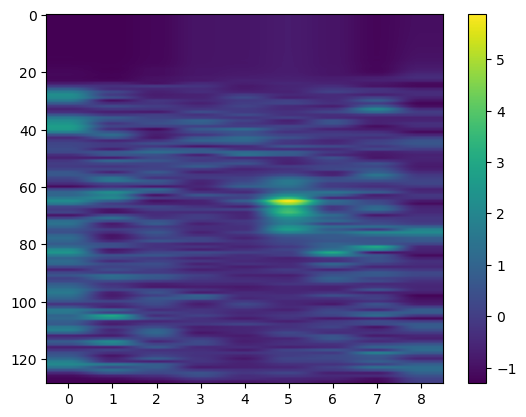

In [47]:
plt.imshow(norm_example[0,:,:], aspect="auto")
plt.colorbar()

In [48]:
# help(norm_layer)

In [49]:
# norm_layer(train_take_example)

In [50]:
norm_layer.variance

<tf.Variable 'normalization/variance:0' shape=(9,) dtype=float32, numpy=
array([1.4667292e-05, 3.4253517e-05, 6.1784514e-05, 1.0820895e-04,
       3.1936372e-04, 3.4664766e-04, 1.1123343e-04, 4.5405090e-05,
       7.8535068e-06], dtype=float32)>

In [51]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 129, 9)            19        
_________________________________________________________________
flatten_2 (Flatten)          (None, 1161)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 2000)              2324000   
_________________________________________________________________
dense_11 (Dense)             (None, 1200)              2401200   
_________________________________________________________________
dense_12 (Dense)             (None, 800)               960800    
_________________________________________________________________
dense_13 (Dense)             (None, 1200)              961200    
_________________________________________________________________
dense_14 (Dense)             (None, 1161)             

In [52]:
model.fit(train_dataset,validation_data=test_dataset, epochs=30)

Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
20/20 [==============================] - 1s 25ms/step - loss: 0.0046 - val_loss: 1.3538e-04
Epoch 2/30
20/20 [==============================] - 0s 21ms/step - loss: 1.3667e-04 - val_loss: 1.3538e-04
Epoch 3/30
20/20 [==============================] - 0s 21ms/step - loss: 1.3623e-04 - val_loss: 1.3538e-04
Epoch 4/30
20/20 [==============================] - 0s 21ms/step - loss: 1.3672e-04

## Looking at predictions
Inspecting the predictions of the model on the training set.

# Note: !!!!!!!!!!!!!!!!!!!!!
The normalization layer seems to be a problem.
Even with just the amplitude and the normalization layer the results are garbage. but not so bad for no normalization...

In [81]:
# release train dataset:
# train_dataset = None
# test_dataset = None
example_count = 2
train_example_data = train_dataset.take(count=example_count)

predictions = model.predict(train_example_data)

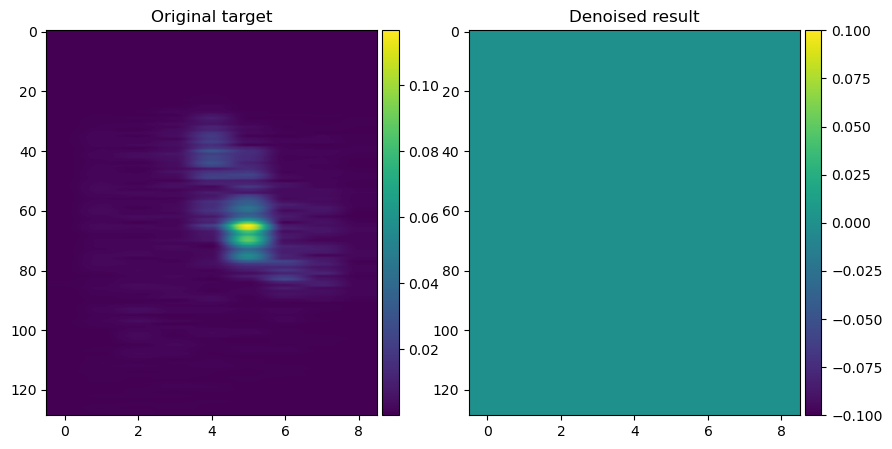

In [82]:
fig, [ax0, ax1] = plt.subplots(1,2)

divider0 = make_axes_locatable(ax0)
divider1 = make_axes_locatable(ax1)

cax0 = divider0.append_axes('right', size='5%', pad=0.05)
cax1 = divider1.append_axes('right', size='5%', pad=0.05)


# plt.imshow(labels[0,:,:,1], aspect="auto")
im0 = ax0.imshow(labels[0,:,:], aspect="auto")
im1 = ax1.imshow(predictions[0,:,:], aspect="auto")
# ax0.colorbar()
# fig.colorbar(im1, cax=ax0_cb, orientation='horizontal')

fig.colorbar(im0, cax=cax0, orientation='vertical')
fig.colorbar(im1, cax=cax1, orientation='vertical')

ax0.set_title("Original target")
ax1.set_title("Denoised result")

fig.set_size_inches((10,5))
# plt.imshow(predictions[0,:,:,1], aspect="auto")
# ax1.imshow(predictions[0,:,:], aspect="auto")

# plt.colorbar()

In [83]:
np.var(predictions)

0.0

In [84]:
predictions.shape

(1024, 129, 9)

In [93]:
predictions.shape

def plot_example(index):
    prediction = predictions[index]
    actual = labels[index]
    noisy = examples[index]
    
    fig, [ax1, ax2, ax3, ax4] = plt.subplots(1,4)

    ax1.imshow(noisy, aspect="auto")
    ax1.set_title("Noisy Original")
    
    ax2.set_title("Denoised result")
    ax2.imshow(prediction, aspect = "auto")
    
    ax3.set_title("Actual ground truth")
    ax3.imshow(actual, aspect= "auto")
    ax4.imshow(actual-prediction, aspect="auto")
    
    fig.set_size_inches((10,5))
    
    plt.show()

In [94]:
interact(plot_example, index=(0, 20, 1))

interactive(children=(IntSlider(value=10, description='index', max=20), Output()), _dom_classes=('widget-inter…

<function __main__.plot_example(index)>

In [ ]:
def plot_time_domain( index):

    test_noisy = noisy_stft.get_data()[index,:,:,0]
    test_noisy_phase = noisy_stft.get_data()[index,:,:,1]

    test_pure = labels[index,:,:]
    test_pure_phase = noisy_stft.get_data()[index,:,:,1]

    model_amp = predictions[index]
    noisy_phase = noisy_stft.get_data()[index,:,:,1]

    fig, [ax1, ax2] =plt.subplots(1,2)
    t, signal_pure = istft(test_pure*np.exp(1j*test_pure_phase), fs = 1./5.)
    t, signal_model = istft(model_amp*np.exp(1j*noisy_phase), fs = 1./5.)
    t, signal_example = istft(test_noisy*np.exp(1j*test_noisy_phase), fs = 1./5.)

    fig.set_size_inches((12,10))
    ax1.plot(t,signal_example)
    ax2.plot(t, signal_model)
    ax2.plot(t, signal_pure, alpha=0.5, color="red")
    plt.show()

In [ ]:
interact(plot_time_domain, index = (0,9999,1))

## Visualize the effect on the test set
Previous visualizations were for the training set only.

Check the influence of the test set here.

In [ ]:
predictions_test = model.predict(examples_test)

In [ ]:
# examples_test = noisy_test_stft.get_data()[::stride_reduce,:,:,:]
# labels_test = pure_test_stft.get_data()[::stride_reduce,:,:,:]

# examples_test_phase = noisy_test_stft.get_data()[::stride_reduce,:,:,:]
# labels_test_phase = pure_test_stft.get_data()[::stride_reduce,:,:,:]

In [ ]:
predictions_test.shape

In [ ]:
labels_test.shape

In [ ]:
index = 10
prediction_current = predictions_test[index]
    
# the pure example from the test set
test_pure = labels_test[index]

pred_amp = prediction_current[:,:,0]
pred_phase = prediction_current[:,:,1]

In [ ]:
pred_amp

In [ ]:
def plot_time_domain_test( index):

    # get the test set prediction
    # test_noisy = examples_test[index]
    # test_noisy_phase = examples_test_phase[index]
    prediction_current = predictions_test[index]
    
    # the pure example from the test set
    test_pure = labels_test[index]

    pred_amp = prediction_current[:,:,0]
    pred_phase = prediction_current[:,:,1]
    
    # model_amp = predictions_test[index]
    # noisy_phase = examples_test_phase[index]

    # calculate the STFT inverse of the deep learning predictions and the actual result
    # t, signal_pure = istft(test_pure*np.exp(1j*test_pure_phase), fs = 1./5.)
    
    t, signal_pred = istft(pred_amp*np.exp(1j*pred_phase), fs = 1./5.)
    # t, signal_example = istft(test_noisy*np.exp(1j*test_noisy_phase), fs = 1./5.)  
    
    fig, [ax1, ax2] =plt.subplots(1,2)

    fig.set_size_inches((12,10))
    # ax1.plot(t,signal_example)
    ax2.plot(t, signal_pred)
    # ax2.plot(t, signal_pure, alpha=0.5, color="red")
    plt.show()

In [ ]:
num_test_examples = examples_test.shape[0]
interact(plot_time_domain_test, index = (0,num_test_examples,1))

## Store the model
Storing the model after a long training session.

In [ ]:
model_folder = "model/"

In [70]:

# Get the current date
now = datetime.datetime.now()

# Format the date as "day-month-year"
date_str = now.strftime("%d-%m-h%H%M")

# 

# Parameter count
trainableParams = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])


model_name = f"model-{date_str}-p{trainableParams}"

In [71]:


path = model_folder + model_name
model.save(path)

INFO:tensorflow:Assets written to: model/model-29-03-h1401-p2941361/assets


## Analysis of maximum values
Looking at maximum values of amplitude over the whole array

In [147]:
test_example = noisy_stft.get_data()[0]
shape = test_example.shape
test_example_reshaped = noisy_stft.get_data()[0].reshape((1, shape[0], shape[1], shape[2]))

test_pure = pure_stft.get_data()[0]

In [148]:
test_pure[:,:,0].max()

0.1167289817731223

Todo
Normalize the phase and amplitude values..

In [27]:
amps_noisy =noisy_stft.get_data()[:,:,:,0]

In [28]:
amps_noisy_flattened = amps_noisy.flatten()

(array([1.0101877e+07, 1.1225070e+06, 1.9600700e+05, 1.0042300e+05,
        5.1438000e+04, 2.1964000e+04, 9.8380000e+03, 4.6260000e+03,
        1.1690000e+03, 1.5100000e+02]),
 array([2.14359953e-11, 1.67539747e-02, 3.35079495e-02, 5.02619242e-02,
        6.70158989e-02, 8.37698737e-02, 1.00523848e-01, 1.17277823e-01,
        1.34031798e-01, 1.50785773e-01, 1.67539747e-01]),
 <BarContainer object of 10 artists>)

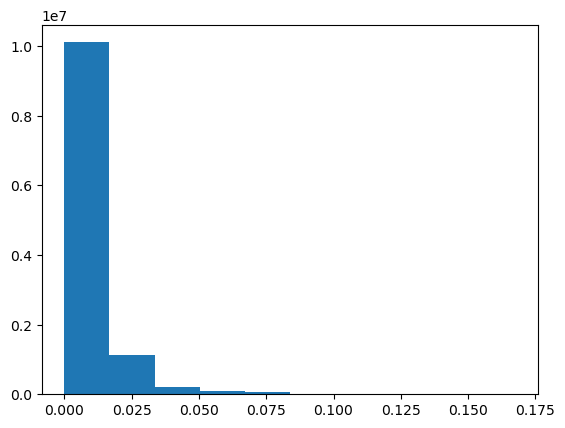

In [29]:
plt.hist(amps_noisy_flattened)

In [30]:
amps_noisy_max = amps_noisy.max(axis=2).max(axis=1)

In [31]:
amps_noisy_max.shape

(10000,)

(array([ 153.,  364., 2132., 2197., 1479., 1392., 1000.,  879.,  345.,
          59.]),
 array([0.04645806, 0.05856623, 0.0706744 , 0.08278256, 0.09489073,
        0.1069989 , 0.11910707, 0.13121524, 0.14332341, 0.15543158,
        0.16753975]),
 <BarContainer object of 10 artists>)

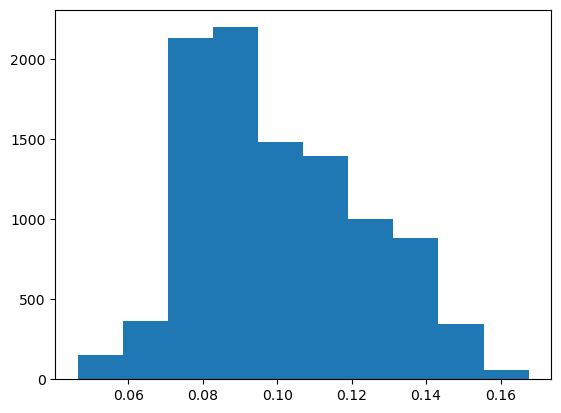

In [32]:
plt.hist(amps_noisy_max)